In [1]:
import cv2 as cv
import numpy as np
import pandas as pd
from PIL import Image, ImageEnhance
import math
import matplotlib.pyplot as plt

In [2]:
def display_bgr2rgp(img):
    rgb_img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    plt.figure(figsize=(10,10))
    plt.imshow(rgb_img)
    plt.show()
    
def preprocess(img, factor=2):
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    img = Image.fromarray(img)
    enhancer = ImageEnhance.Sharpness(img).enhance(factor)
    if gray.std() < 30:
        enhancer = ImageEnhance.Contrast(enhancer).enhance(factor)
    return np.array(enhancer)

def cell_in_same_row(c1, c2):
    c1_center = c1[1] + c1[3] - c1[3] / 2
    c2_bottom = c2[1] + c2[3]
    c2_top = c2[1]
    return c2_top < c1_center < c2_bottom

def avg_height_of_center(row):
    centers = [y + h - h / 2 for x, y, w, h in row]
    return sum(centers) / len(centers)


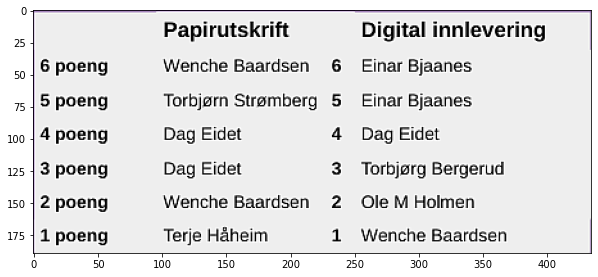

In [3]:
img_path = "images/19.png"

img = cv.imread(img_path)
img = preprocess(img, 2)

display_bgr2rgp(img)

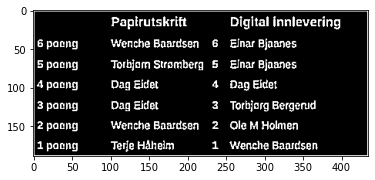

In [6]:
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
cv.rectangle(gray, (0,0), gray.shape[::-1], 0, 2)
blur = cv.GaussianBlur(gray, (3,3), 0, 0)
thresh = cv.adaptiveThreshold(~blur,255,cv.ADAPTIVE_THRESH_MEAN_C,cv.THRESH_BINARY,5,-2,)

plt.imshow(thresh, cmap='gray')
plt.show()

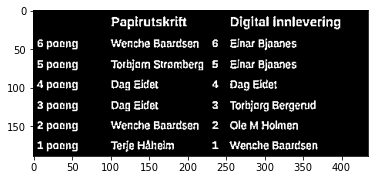

In [7]:
cv.rectangle(thresh, (0,0), thresh.shape[::-1], 0, 2)
plt.imshow(thresh, cmap='gray')
plt.show()

In [64]:
vertical = horizontal = thresh.copy()
img_height, img_width = horizontal.shape

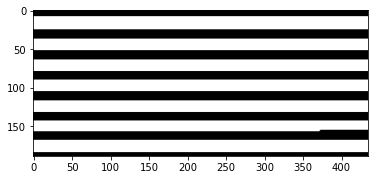

In [65]:
SCALE = 10
horizontal_kernel = cv.getStructuringElement(cv.MORPH_RECT, (int(img_width / SCALE), 1))
hor_dilate = cv.dilate(horizontal, horizontal_kernel, iterations=15)
plt.imshow(hor_dilate, cmap='gray')
plt.show()

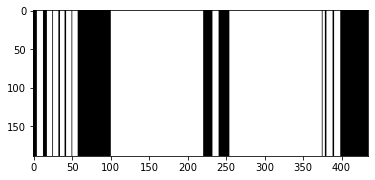

In [66]:
vertical_kernel = cv.getStructuringElement(cv.MORPH_RECT, (1,int(img_width / SCALE)))
ver_dilate = cv.dilate(horizontal, vertical_kernel, iterations=15)
plt.imshow(ver_dilate, cmap='gray')
plt.show()

In [80]:
contours, hierarchy = cv.findContours(hor_dilate, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
len(contours)

7

In [81]:
bounding_rects = [cv.boundingRect(c) for c in contours]
bounding_rects

[(0, 168, 435, 16),
 (0, 143, 435, 14),
 (0, 117, 435, 15),
 (0, 90, 435, 15),
 (0, 64, 435, 15),
 (0, 37, 435, 15),
 (0, 8, 435, 17)]

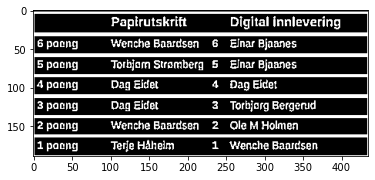

In [82]:
tc1 = thresh.copy()

new_bnd = []
for b in bounding_rects:
    temp = list(b)
    temp[1] = max(temp[1] - 5, 0)
    temp[3] += 10
    new_bnd.append(temp)

for b in new_bnd:
    cv.rectangle(tc1, (b[0], b[1]), (b[0] + b[2], b[1]+ b[3]), 255, 2)
    
plt.imshow(tc1, cmap='gray')
plt.show()

In [83]:
bounding_rects

[(0, 168, 435, 16),
 (0, 143, 435, 14),
 (0, 117, 435, 15),
 (0, 90, 435, 15),
 (0, 64, 435, 15),
 (0, 37, 435, 15),
 (0, 8, 435, 17)]

In [84]:
contours, hierarchy = cv.findContours(ver_dilate, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
len(contours)

12

In [85]:

bounding_rects = [cv.boundingRect(c) for c in contours]
bounding_rects

[(391, 0, 8, 189),
 (381, 0, 8, 189),
 (376, 0, 3, 189),
 (255, 0, 120, 189),
 (233, 0, 8, 189),
 (101, 0, 120, 189),
 (51, 0, 7, 189),
 (43, 0, 7, 189),
 (35, 0, 6, 189),
 (26, 0, 7, 189),
 (18, 0, 7, 189),
 (5, 0, 8, 189)]

In [86]:
# bounding_rects.sort(key = lambda b: b[0])
# bounding_rects

In [87]:
MIN_COLUMN_SPACE = 12

def check_combine(a, b):
    x1, y1, w1, h1 = a
    x2, y2, w2, h2 = b
    
    col_space = x2 - (x1 + w1) + 1
    if col_space < MIN_COLUMN_SPACE:
        new_rect = (x1, min(y1, y2), w2+x2-x1+1, max(h1, h2))
        return new_rect
    else:
        return False
    

def reduce(rects):
    cursor = len(rects) - 1
    while cursor > 0:
        last = rects[cursor]
        next_last = rects[cursor-1] if rects[cursor-1] else None
        if next_last:
            check = check_combine(last, next_last)
            if check != False:
                rects.pop(cursor)
                rects.pop(cursor - 1)
                rects.insert(cursor-1, check)
        cursor -= 1
    return rects
    
bounding_rects = reduce(bounding_rects)    

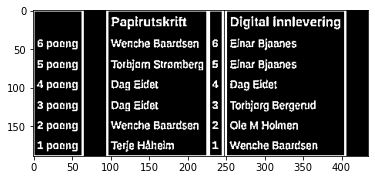

In [88]:
tc2 = thresh.copy()
new_bnd = []
for b in bounding_rects:
    temp = list(b)
    temp[0] = max(temp[0] - 5, 0)
    temp[2] += 10
    new_bnd.append(temp)


for b in new_bnd:
    cv.rectangle(tc2, (b[0], b[1]), (b[0] + b[2], b[1]+ b[3]), 255, 2)
    
plt.imshow(tc2, cmap='gray')
plt.show()

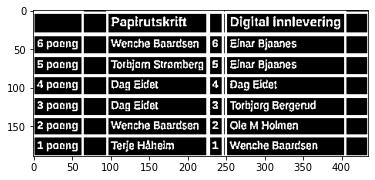

In [89]:
border_table = tc1 + tc2
plt.imshow(border_table, cmap='gray')
plt.show()

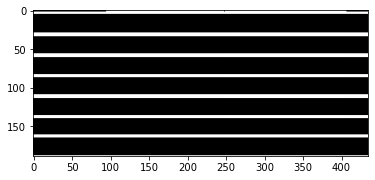

In [90]:
vertical = horizontal = border_table.copy()
img_height, img_width = horizontal.shape
SCALE = 3
horizontal_kernel = cv.getStructuringElement(cv.MORPH_RECT, (int(img_width / SCALE), 1))
horizontally_opened = cv.morphologyEx(border_table, cv.MORPH_OPEN, horizontal_kernel)
plt.imshow(horizontally_opened, cmap='gray')
plt.show()

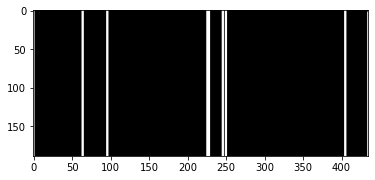

In [91]:
vertical_kernel = cv.getStructuringElement(cv.MORPH_RECT, (1, int(img_height / SCALE)))
vertically_opened = cv.morphologyEx(border_table, cv.MORPH_OPEN, vertical_kernel)
plt.imshow(vertically_opened, cmap='gray')
plt.show()

In [106]:
mask = horizontally_opened + vertically_opened
contours, hierarchy = cv.findContours(mask, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

perimeter_lengths = [cv.arcLength(c, True) for c in contours]
epsilons = [0.1 * p for p in perimeter_lengths]
approx_polys = [cv.approxPolyDP(c, e, True) for c, e in zip(contours, epsilons)]

bounding_rects = [cv.boundingRect(a) for a in approx_polys]


MIN_RECT_WIDTH = 10
MIN_RECT_HEIGHT = 10
bounding_rects = [
    r for r in bounding_rects if MIN_RECT_WIDTH < r[2] and MIN_RECT_HEIGHT < r[3]
]

largest_rect = max(bounding_rects, key=lambda r: r[2] * r[3])
bounding_rects = [b for b in bounding_rects if b is not largest_rect]

cells = [c for c in bounding_rects]
print(len(cells))

42


In [107]:
rows = []
while cells:
    first = cells[0]
    rest = cells[1:]
    cells_in_same_row = sorted([c for c in rest if cell_in_same_row(c, first)], key=lambda c: c[0])

    row_cells = sorted([first] + cells_in_same_row, key=lambda c: c[0])
    rows.append(row_cells)
    cells = [c for c in rest if not cell_in_same_row(c, first)]
        
rows.sort(key=avg_height_of_center)

In [108]:
rows

[[(1, 4, 63, 26),
  (65, 4, 31, 26),
  (97, 5, 129, 24),
  (229, 4, 17, 26),
  (251, 5, 154, 24),
  (406, 4, 29, 26)],
 [(1, 33, 63, 24),
  (65, 33, 31, 24),
  (97, 34, 129, 22),
  (229, 33, 17, 24),
  (251, 34, 154, 22),
  (406, 33, 29, 24)],
 [(1, 60, 63, 24),
  (65, 60, 31, 24),
  (97, 61, 129, 22),
  (229, 60, 17, 24),
  (251, 61, 154, 22),
  (406, 60, 29, 24)],
 [(1, 86, 63, 24),
  (65, 86, 31, 24),
  (97, 87, 129, 22),
  (229, 86, 17, 24),
  (251, 87, 154, 22),
  (406, 86, 29, 24)],
 [(1, 113, 63, 24),
  (65, 113, 31, 24),
  (97, 114, 129, 22),
  (229, 113, 17, 24),
  (251, 114, 154, 22),
  (406, 113, 29, 24)],
 [(1, 139, 63, 23),
  (65, 139, 31, 23),
  (97, 140, 129, 21),
  (229, 139, 17, 23),
  (251, 140, 154, 21),
  (406, 139, 29, 23)],
 [(1, 164, 63, 25),
  (65, 164, 31, 25),
  (97, 165, 129, 23),
  (229, 164, 17, 25),
  (251, 165, 154, 23),
  (406, 164, 29, 25)]]

In [109]:
new_rows = []
for row in rows:
    new_row_cell = []
    for cell in row:
        cx, cy, cw, ch = cell
        cell_thresh = thresh[cy:cy+ch, cx:cx+cw]
                
        ver = hor = cell_thresh.copy()
        ih, iw = hor.shape

        hor_kernel = cv.getStructuringElement(cv.MORPH_RECT, (int(iw/3), 1))
        ver_kernel = cv.getStructuringElement(cv.MORPH_RECT, (1, int(ih/3)))
        hor_opened = cv.morphologyEx(hor, cv.MORPH_OPEN, hor_kernel)
        ver_opened = cv.morphologyEx(ver, cv.MORPH_OPEN, ver_kernel)

        both = hor_opened + ver_opened
        clean = cell_thresh - both

        kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (3, 3))
        opened = cv.morphologyEx(clean, cv.MORPH_OPEN, kernel)
        opened = cv.dilate(clean, kernel)
        contours, hierarchy = cv.findContours(opened, cv.RETR_LIST, cv.CHAIN_APPROX_SIMPLE)
        bounding_rects = [cv.boundingRect(c) for c in contours]
        FIXED_PX = 2
        MIN_CHAR_AREA =  30
        char_sized_bounding_rects = [(x, y, w, h) for x, y, w, h in bounding_rects if w * h > MIN_CHAR_AREA]
        if char_sized_bounding_rects:
            minx, miny, maxx, maxy = math.inf, math.inf, 0, 0
            for x, y, w, h in char_sized_bounding_rects:
                minx = min(minx, x)
                miny = min(miny, y)
                maxx = max(maxx, x + w)
                maxy = max(maxy, y + h)
            x, y, w, h = minx, miny, maxx - minx, maxy - miny
            cropped = (cx+x, cy+y, min(iw, w), min(ih, h+FIXED_PX))
        else:
            cropped = (0,0,0,0)
        new_row_cell.append(cropped)
    new_rows.append(new_row_cell)

In [110]:
new_rows

[[(0, 0, 0, 0),
  (0, 0, 0, 0),
  (101, 7, 100, 22),
  (0, 0, 0, 0),
  (256, 7, 144, 21),
  (0, 0, 0, 0)],
 [(5, 37, 54, 18),
  (0, 0, 0, 0),
  (100, 37, 114, 15),
  (232, 37, 9, 15),
  (255, 37, 88, 15),
  (0, 0, 0, 0)],
 [(5, 64, 54, 18),
  (0, 0, 0, 0),
  (100, 63, 120, 19),
  (232, 66, 9, 10),
  (255, 64, 88, 15),
  (0, 0, 0, 0)],
 [(4, 90, 55, 18),
  (0, 0, 0, 0),
  (103, 90, 56, 17),
  (232, 90, 9, 15),
  (255, 89, 62, 19),
  (0, 0, 0, 0)],
 [(5, 117, 54, 18),
  (0, 0, 0, 0),
  (103, 117, 56, 17),
  (232, 118, 9, 14),
  (255, 116, 111, 19),
  (0, 0, 0, 0)],
 [(5, 143, 52, 17),
  (0, 0, 0, 0),
  (100, 143, 114, 15),
  (232, 145, 9, 10),
  (255, 143, 88, 15),
  (0, 0, 0, 0)],
 [(5, 169, 54, 18),
  (0, 0, 0, 0),
  (100, 167, 82, 20),
  (0, 0, 0, 0),
  (254, 169, 108, 15),
  (0, 0, 0, 0)]]

In [111]:
def remove_empty_cell(rows):
    
    for row in rows:
        try:
            while True:
                row.remove((0,0,0,0))
        except ValueError: 
            pass
    # change to 1d list 
    result = []
    for row in rows:
        result += row
    return result 
            
result = remove_empty_cell(new_rows)
result

[(101, 7, 100, 22),
 (256, 7, 144, 21),
 (5, 37, 54, 18),
 (100, 37, 114, 15),
 (232, 37, 9, 15),
 (255, 37, 88, 15),
 (5, 64, 54, 18),
 (100, 63, 120, 19),
 (232, 66, 9, 10),
 (255, 64, 88, 15),
 (4, 90, 55, 18),
 (103, 90, 56, 17),
 (232, 90, 9, 15),
 (255, 89, 62, 19),
 (5, 117, 54, 18),
 (103, 117, 56, 17),
 (232, 118, 9, 14),
 (255, 116, 111, 19),
 (5, 143, 52, 17),
 (100, 143, 114, 15),
 (232, 145, 9, 10),
 (255, 143, 88, 15),
 (5, 169, 54, 18),
 (100, 167, 82, 20),
 (254, 169, 108, 15)]

In [112]:
len(result)

25